In [1]:
# install these libraries if you don't already have them
# !pip install facebook_scraper
# !pip install vaderSentiment
# !pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections.abc import Iterable
from facebook_scraper import get_posts 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.matcher import PhraseMatcher
import statsmodels.api as sm

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})

In [2]:
listposts = []

for post in get_posts('newswireLK', cookies="/Users/kelumrubasin/Desktop/MSC_DATA_SCIENCE/1_Social_Media_Analytics/Assignment_CIS7029/facebook_data/facebook.com_cookies.txt",
                      pages=25,
                      options={'comments': True}):
    listposts.append(post)
    
print('Number of posts: {}'.format(len(listposts)))   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/facebook_scraper/facebook_scraper.py:881: UserWarning: Facebook says 'Unsupported Browser'
  warnings.warn(f"Facebook says 'Unsupported Browser'")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateparser/freshness_date_parser.py:76: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  now = self.get_local_tz().localize(now)


Number of posts: 97


In [3]:
columns = ['post_id', 
           'time',  
           'text', 
           'likes',
           'comments', 
           'shares', 
           'comments_full']

df_posts = pd.DataFrame(listposts)[columns]

In [4]:
df_posts['text'].replace('', np.nan, inplace=True)

In [5]:
df_posts.dropna(subset=['text'], inplace=True)

In [6]:
from langdetect import detect

def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df_posts = df_posts[df_posts['text'].apply(detect_en)]
df_posts

,post_id,time,text,likes,comments,shares,comments_full
0,592950545599723,2022-07-22 23:09:14,Police release long statement justifying actio...,199,5,20,"[{'comment_id': '465639392065413', 'comment_ur..."
1,592927968935314,2022-07-22 22:30:27,The Human Rights Council Sri Lanka Core Group ...,636,35,127,"[{'comment_id': '1462383337507378', 'comment_u..."
2,592925648935546,2022-07-22 22:27:12,Two individuals die while waiting in fuel queu...,79,6,62,[]
3,592872128940898,2022-07-22 20:45:38,“Gravely concerned by the use of force to disp...,101,7,9,[]
4,592861305608647,2022-07-22 20:26:22,Even Suwaseriya couldn't enter Galle Face prot...,165,8,186,[]
...,...,...,...,...,...,...,...
90,589498049278306,2022-07-17 16:43:50,A new way to get Fuel : Mobile Fuel Dispensers...,1000,140,149,[]
92,589320085962769,2022-07-17 12:47:40,All you need to know about the National Fuel P...,281,46,247,[]
93,588957729332338,2022-07-17 00:58:37,Minster gives update on National Fuel Pass\n\n...,658,326,50,[]
94,588894829338628,2022-07-16 23:04:57,Group of lankans launch #SriLankaDollarChallen...,1000,70,414,[]


In [7]:
analyzer = SentimentIntensityAnalyzer()

list_comments = []
for index, row in df_posts.iterrows():
    post_id = row['post_id']
    if isinstance(row['comments_full'], Iterable):
        for comment in row['comments_full']:
            dict_temp = {}
            dict_temp['post_id'] = post_id
            dict_temp['comment'] = comment['comment_text']
            dict_temp['sentiment'] = analyzer.polarity_scores(
                comment['comment_text'])['compound']
            list_comments.append(dict_temp)        

df_comments = pd.DataFrame(list_comments)

In [9]:
from langdetect import detect

def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df_comments = df_comments[df_comments['comment'].apply(detect_en)]
df_comments

,post_id,comment,sentiment
0,592950545599723,134 in numbers. ! Clearly shows who are they. ...,0.3956
2,592927968935314,We don't need statements .\nWe need strong act...,0.5106
3,592927968935314,Leaders keep proving to the international that...,-0.2732
4,592927968935314,How ugly & disgusting the way those people wer...,-0.9300
5,592927968935314,I DONT THINK ANYONE COULD DO ANYTHING OTHER TH...,-0.3818
6,592927968935314,Ranil knows the low putha!\nHRC won’t take any...,-0.3382
7,592927968935314,now the world 🗺️ has a new police and military...,-0.4767
8,592927968935314,Who appointed this core group?,0.0000
13,592927968935314,Now no more foreign donation and IMF,-0.2960


In [10]:
posts_sentiment = df_comments.groupby('post_id').mean()

df_posts = df_posts.join(posts_sentiment, on=['post_id'])

df_posts.drop(columns=['comments_full'], inplace=True)
df_posts.fillna(0.0, inplace=True)

with pd.ExcelWriter('NewsWireLK.xlsx') as writer:
    df_posts.to_excel(writer, sheet_name='posts_data', index_label='ID')
    df_comments.to_excel(writer, sheet_name='posts_comments', index_label='ID')
    

In [11]:
# Load data from exisiting files to save time
df_posts = pd.read_excel('NewsWireLK.xlsx', sheet_name='posts_data')
df_comments = pd.read_excel('NewsWireLK.xlsx', sheet_name='posts_comments')

In [12]:
# print out dataframe for posts 
df_posts.head()

,ID,post_id,time,text,likes,comments,shares,sentiment
0,0,592950545599723,2022-07-22 23:09:14,Police release long statement justifying actio...,199,5,20,0.395600
1,1,592927968935314,2022-07-22 22:30:27,The Human Rights Council Sri Lanka Core Group ...,636,35,127,-0.273162
2,2,592925648935546,2022-07-22 22:27:12,Two individuals die while waiting in fuel queu...,79,6,62,0.000000
3,3,592872128940898,2022-07-22 20:45:38,“Gravely concerned by the use of force to disp...,101,7,9,0.000000
4,4,592861305608647,2022-07-22 20:26:22,Even Suwaseriya couldn't enter Galle Face prot...,165,8,186,0.000000


In [13]:
# print out dataframe for comments 
df_comments.head()

,ID,post_id,comment,sentiment
0,0,592950545599723,134 in numbers. ! Clearly shows who are they. ...,0.3956
1,2,592927968935314,We don't need statements .\nWe need strong act...,0.5106
2,3,592927968935314,Leaders keep proving to the international that...,-0.2732
3,4,592927968935314,How ugly & disgusting the way those people wer...,-0.9300
4,5,592927968935314,I DONT THINK ANYONE COULD DO ANYTHING OTHER TH...,-0.3818


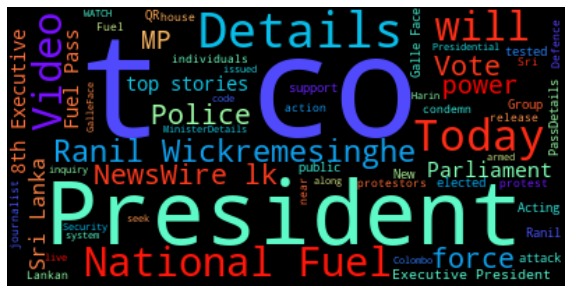

In [14]:
# merge all texts in posts
post_text = ' '.join([str(i) for i in df_posts['text']])
post_text = post_text.replace('\n', '') # remove blank lines characters

# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'gov', 'au', 'nsw', 's', 're'])

# Generate a word cloud image
wordcloud = WordCloud(random_state=1, 
                      collocations=True, 
                      stopwords=stopwords,
                      max_words=60,
                      background_color='black',
                      colormap ='rainbow',
                      contour_color='steelblue').generate(post_text)

# Function to display word cloud img via matplotlib
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plot world cloud    
plot_cloud(wordcloud)

In [110]:
# list of common products / services
products = ['police', 'president', 'fuel', 'ranil', 'force', 
            'vote', 'sri lanka', 'will', 'today', 'co']

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Create the PhraseMatcher object. The tokenizer is the first argument. Use attr = 'LOWER' to make consistent capitalization
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

# Only run nlp.make_doc to speed things up
prod_tokens = [nlp.make_doc(text) for text in products]

# Add the item patterns to the matcher
matcher.add("NewWireLKTopics", prod_tokens)

In [111]:
# Use defaultdict to create dictionary of sentiment scores by product
# If a key doesn't exist in item_ratings, the key is added with an empty list as the value.
product_sentiment = defaultdict(list)
product_likes = defaultdict(list)

# add sentiment scores from posts to each product
for idx, post in df_posts.iterrows():
    doc = nlp(post.loc['text'])
    
    # Using the matcher created before
    matches = matcher(doc)
    
    # Create a set of the items found in the review text
    found_products = set()
    for match_id, start, end in matches:
        product = doc[start:end].text.lower() # remove case sensitives
        found_products.add(product)
    
    # add sentiment scores to each products found in post
    for product in found_products:
        product_sentiment[product].append(post.sentiment)
        product_likes[product].append(post.likes)

<AxesSubplot:ylabel='Sentiment score'>

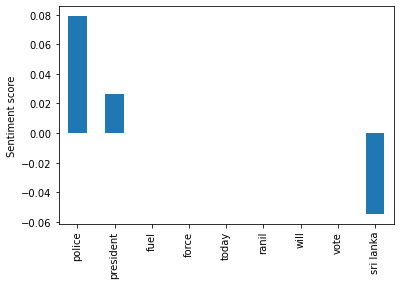

In [112]:
# Calculate the mean sentiment score for each product
mean_sentiment = {}

for product, score in product_sentiment.items():
    avg_score = sum(score) / len(score)
    mean_sentiment[product] = avg_score

# create dataframe for sentiment scores by product    
df_prod_sentiment = pd.DataFrame(mean_sentiment, index=['sentiment']).transpose()
df_prod_sentiment = df_prod_sentiment.sort_values(by=['sentiment'], ascending=False)

# plot sentiment score by products
df_prod_sentiment.plot(kind='bar', legend=False, ylabel='Sentiment score')

<AxesSubplot:ylabel='Number of Likes'>

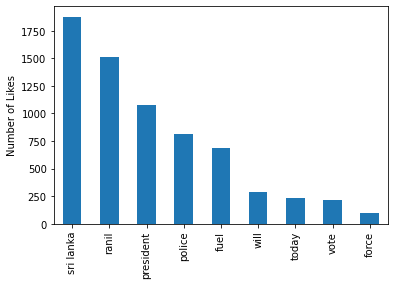

In [113]:
# Calculate the avg number of likes  for each product
mean_likes = {}

for product, likes in product_likes.items():
    avg_likes = sum(likes) / len(likes)
    mean_likes[product] = avg_likes

# create dataframe for sentiment scores by product    
df_prod_likes = pd.DataFrame(mean_likes, index=['likes']).transpose()
df_prod_likes = df_prod_likes.sort_values(by=['likes'], ascending=False)

# plot sentiment score by products
df_prod_likes.plot(kind='bar', legend=False, ylabel='Number of Likes')

In [114]:
df_posts_new = df_posts # create a new df to incorporate new features

# create df for product term counts by FB posts
df_product_terms = pd.DataFrame(columns=products, index=df_posts_new.index)
df_product_terms.fillna(0, inplace=True) # remove NA in order to add increments

# count product term matches for each posts
for idx, post in df_posts_new.iterrows():
    doc = nlp(post.loc['text'])
    
    # Using the matcher created before
    matches = matcher(doc)
    
    # Create a set of the items found in the review text
    for match_id, start, end in matches:
        product = doc[start:end].text.lower() # remove case sensitives
        df_product_terms.loc[idx, product] += 1

In [115]:
# add product term counts to df
df_posts_new = df_posts_new.join(df_product_terms)

# predictors and target variable
features = ['likes', 'comments', 'shares'] + products
X = df_posts_new[features]
y = df_posts_new['sentiment']

# fit OLS model using statmodels api
X = sm.add_constant(X, prepend=False) # add constant term
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     2.547
Date:                Sat, 23 Jul 2022   Prob (F-statistic):            0.00979
Time:                        00:57:40   Log-Likelihood:                 108.01
No. Observations:                  66   AIC:                            -190.0
Df Residuals:                      53   BIC:                            -161.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
likes      -1.512e-05   1.51e-05     -1.005      0.3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
